# Testing Pair Trading 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import nsepy
import quandl
import datetime
import numpy as np
from statsmodels.tsa.stattools import coint

In [4]:
start = datetime.date(year=2021, month=12, day=1)
end = datetime.date(year=2022, month=10, day=30)


### NIFTY BANK & NIFTY 50

In [5]:
df1 = nsepy.get_history('BANKNIFTY', start=start, end=end,index=True)
df2 = nsepy.get_history('NIFTY', start=start, end=end,index=True)


In [7]:
print(df1.tail(1))
print(df2.tail(1))

               Open     High      Low     Close     Volume      Turnover
Date                                                                    
2022-10-28  41236.8  41482.4  40839.3  40990.85  237123178  5.336090e+10
               Open     High      Low    Close     Volume      Turnover
Date                                                                   
2022-10-28  17756.4  17838.9  17723.7  17786.8  250030113  1.909959e+11


In [8]:
df1_returns = df1['Close'].pct_change()
df2_returns = df2['Close'].pct_change()

In [10]:
df1['adj_close'] = df1['Close'] /df1['Close'].iloc[0]
df2['adj_close'] = df2['Close'] /df2['Close'].iloc[0]

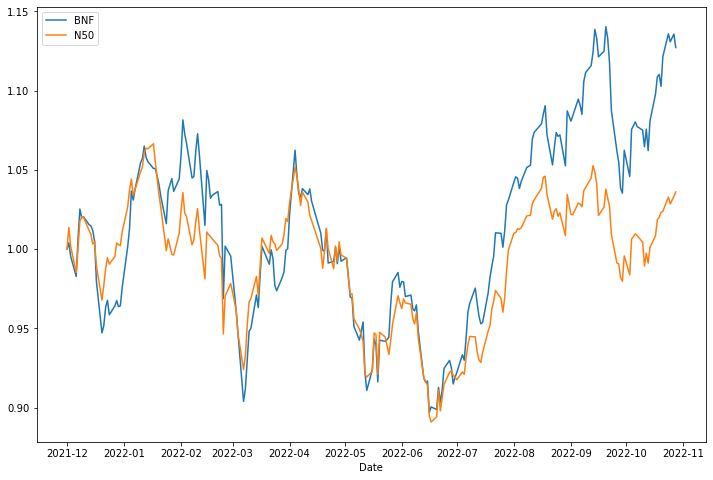

In [11]:

df1['adj_close'].plot(label='BNF',figsize=(12,8))
df2['adj_close'].plot(label='N50')
plt.legend()

# Spread and Correlation

In [12]:
np.corrcoef(df1['Close'],df2['Close'])

array([[1.       , 0.8477386],
       [0.8477386, 1.       ]])

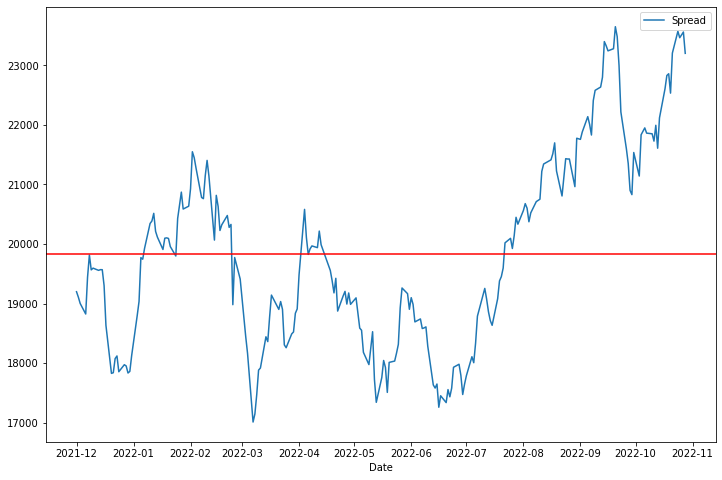

In [13]:
spread = df1['Close'] - df2['Close']
spread.plot(label='Spread',figsize=(12,8))
plt.axhline(spread.mean(),c='r')
plt.legend()

## Normalizing with a z-score

In [14]:
def zscore(stocks):
    return (stocks - stocks.mean()) / np.std(stocks)

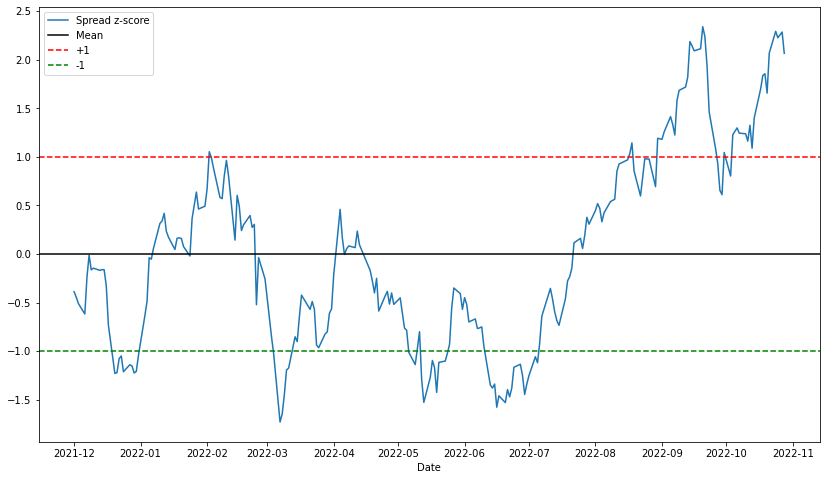

In [15]:
zscore(spread).plot(figsize=(14,8))
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, c='r', ls='--')
plt.axhline(-1.0, c='g', ls='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

Rolling Z-Score

Our spread is currently NIFTYBANK/NIFTY50. Let's decide how to calculate this on a rolling basis.

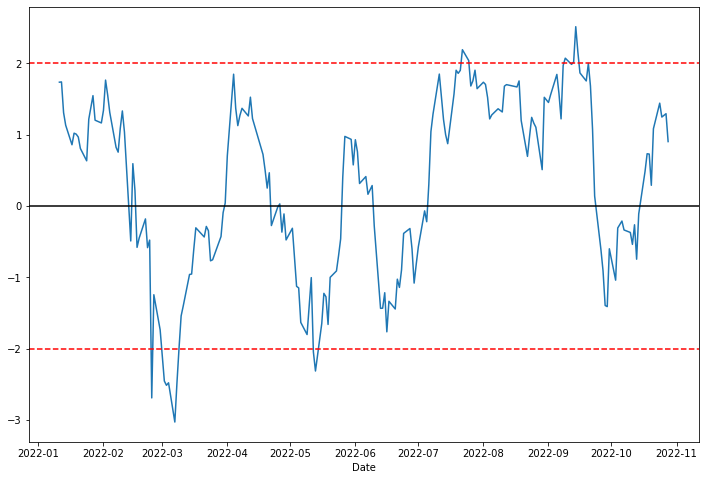

In [16]:
#1 day moving average of the price spread
spread_mavg1 = spread.rolling(1).mean()

# 30 day moving average of the price spread
spread_mavg30 = spread.rolling(30).mean()

# Take a rolling 30 day standard deviation
std_30 = spread.rolling(30).std()

# Compute the z score for each day
zscore_30_1 = (spread_mavg1 - spread_mavg30)/std_30



zscore_30_1.plot(figsize=(12,8),label='Rolling 30 day Z score')
plt.axhline(0, color='black')
plt.axhline(2.0, color='red', linestyle='--');
plt.axhline(-2.0, color='red', linestyle='--');

In [17]:
# compute the p-value of the cointegration test
# will inform us as to whether the spread btwn the 2 timeseries is stationary
# around its mean
score, pvalue, _ = coint(df1['Close'],df2['Close'])
print (pvalue)

0.7469079003111683


<AxesSubplot:xlabel='Date'>

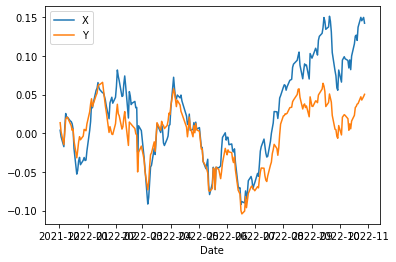

In [18]:
X_diverging = pd.Series(np.cumsum(df1_returns), name='X')
Y_diverging = pd.Series(np.cumsum(df2_returns), name='Y')

pd.concat([X_diverging, Y_diverging], axis=1).plot()